In [1]:
import numpy as np
import xarray as xr
from matplotlib import pyplot as plt
plt.rcParams['figure.facecolor'] = 'white'
import cmocean.cm as cmo
%config InlineBackend.print_figure_kwargs = {'bbox_inches': None}
from matplotlib.patches import Rectangle
import json

In [2]:
def get_stuff_at_y(ht, y, mld):
    HT = ht.isel(YG=y)
    MLD = mld.isel(YG=y).values
    HT_in_ML = HT.where(HT.Z >= -MLD, other=0)
    drF_in_ML = HT.drF.where(HT.Z.values >= -MLD, other=0)
    HT_total_ML = (HT_in_ML * drF_in_ML.data).sum("Z")
    HT_out_ML = HT.where(HT.Z < -MLD, other=0)
    return MLD, HT_total_ML, HT_out_ML

In [3]:
path = "../data_for_plots/" 

In [4]:
mean = xr.open_mfdataset(path + "mean_heat_transports_0201-01-01_0300-12-30_JJA_NoML_zonal_integral.nc")
transient = xr.open_mfdataset(path + "transient_heat_transports_0201-01-01_0300-12-30_JJA_NoML_zonal_integral.nc")
isopycnal = xr.open_mfdataset(path + "isopycnal_heat_transports_0201-01-01_0300-12-30_JJA_NoML_zonal_integral.nc")

In [26]:
MLD = xr.open_mfdataset(path + "MXLDEPTH_0201-01-01_0300-12-30_JJA_zonal_mean.nc").MXLDEPTH
T = xr.open_mfdataset(path + "THETA_0201-01-01_0300-12-30_JJA_zonal_mean.nc").THETA
SIG2 = xr.open_mfdataset(path + "SIG2_0201-01-01_0300-12-30_JJA_zonal_mean.nc").SIG2
MOC_res = xr.open_mfdataset(path + "MOC_res_0201-01-01_0300-12-30_JJA.nc").MOC_res
MOC_res_z = xr.open_mfdataset(path + "MOC_res_z_0201-01-01_0300-12-30_JJA.nc").MOC_res_z
T_rho = xr.open_mfdataset(path + "T_on_isopycnals_0201-01-01_0300-12-30_JJA_zonal_mean.nc")

In [14]:
with open(path + 'table_of_fluxes.JJA.json', 'r', encoding='utf-8') as f: 
    tof = json.load(f)
f.close()

In [15]:
SIarea = xr.open_mfdataset(path + "SIarea_0201-01-01_0300-12-30_JJA_zonal_mean.nc")
SIheff = xr.open_mfdataset(path + "SIheff_0201-01-01_0300-12-30_JJA_zonal_mean.nc")

In [16]:
SIedge15 = len(SIarea.YC) - SIarea.SIarea.where(SIarea.SIarea <= 0.15, other=1)[::-1].argmax("YC").values
SIedge80 = len(SIarea.YC) - SIarea.SIarea.where(SIarea.SIarea <= 0.80, other=1)[::-1].argmax("YC").values

In [17]:
ML_at_190, THTdiv_ML_at_190, THTdiv_outside_ML_190 = get_stuff_at_y(
    transient.THTdiv * transient.drF * 1e16, 190, MLD)
ML_at_S15, THTdiv_ML_at_S15, THTdiv_outside_ML_S15 = get_stuff_at_y(
    transient.THTdiv * transient.drF * 1e16, SIedge15, MLD)
ML_at_S80, THTdiv_ML_at_S80, THTdiv_outside_ML_S80 = get_stuff_at_y(
    transient.THTdiv * transient.drF * 1e16, SIedge80, MLD)
ML_at_080, THTdiv_ML_at_080, THTdiv_outside_ML_080 = get_stuff_at_y(
    transient.THTdiv * transient.drF * 1e16, 80, MLD)

_, THTdiveddy_ML_at_190, THTdiveddy_outside_ML_190 = get_stuff_at_y(
    transient.THTdiveddy * transient.drF * 1e12, 190, MLD)
_, THTdiveddy_ML_at_S15, THTdiveddy_outside_ML_S15 = get_stuff_at_y(
    transient.THTdiveddy * transient.drF * 1e12, SIedge15, MLD)
_, THTdiveddy_ML_at_S80, THTdiveddy_outside_ML_S80 = get_stuff_at_y(
    transient.THTdiveddy * transient.drF * 1e12, SIedge80, MLD)
_, THTdiveddy_ML_at_080, THTdiveddy_outside_ML_080 = get_stuff_at_y(
    transient.THTdiveddy * transient.drF * 1e12, 80, MLD)

_, MHT_ML_at_190, MHT_outside_ML_190 = get_stuff_at_y(
    mean.MHT * mean.drF * 1e12, 190, MLD)
_, MHT_ML_at_S15, MHT_outside_ML_S15 = get_stuff_at_y(
    mean.MHT * mean.drF * 1e12, SIedge15, MLD)
_, MHT_ML_at_S80, MHT_outside_ML_S80 = get_stuff_at_y(
    mean.MHT * mean.drF * 1e12, SIedge80, MLD)
_, MHT_ML_at_080, MHT_outside_ML_080 = get_stuff_at_y(
    mean.MHT * mean.drF * 1e12, 80, MLD)

Some functions for the plotting

In [18]:
def axtrans(ax, var1, var2, var3, y, kwarg_dict):
    c1 = ax.plot(var1, y, color=kwarg_dict["color1"], ls=kwarg_dict["ls1"], label=kwarg_dict["label1"])
    c2 = ax.plot(var2, y, color=kwarg_dict["color2"], ls=kwarg_dict["ls2"], label=kwarg_dict["label2"])
    if (var3 != None).all():
        c3 = ax.plot(var3, y, color=kwarg_dict["color3"], ls=kwarg_dict["ls3"], label=kwarg_dict["label3"])
    ax.patch.set_facecolor("w")
    ax.patch.set_alpha(0.)
    ax.set_ylim(kwarg_dict["bottomylim"], kwarg_dict["topylim"])
    ax.set_xlim(kwarg_dict["HTxmin"], kwarg_dict["HTxmax"])
    ax.spines.top.set_visible(False)
    ax.spines.left.set_visible(False)
    ax.spines.right.set_visible(False)
    ax.spines.bottom.set_visible(False)
    ax.set_yticks([])
    ax.grid(color=kwarg_dict["color1"], ls=":")
    ax.set_xticks(kwarg_dict["HTxticks"])
    ax.set_xticklabels(kwarg_dict["HTxticklabels"])
    ax.set_xlabel(kwarg_dict["xlabel"], color=kwarg_dict["color1"])
    ax.tick_params(axis='x', colors=kwarg_dict["color1"], labelsize=11.5)

In [19]:
def hbars(cats, vals, errs, ax, bw):
    bar = ax.barh(cats, vals, xerr=errs, align='center', color=["steelblue", "steelblue", "k"],
                  hatch=["|||", "", ""], height=bw)
    no_axes(ax)
    return bar

In [20]:
def no_axes(ax):
    ax.spines.left.set_visible(False)
    ax.spines.right.set_visible(False)
    ax.spines.top.set_visible(False)
    ax.spines.bottom.set_visible(False)
    ax.set_yticks([])
    ax.set_xticks([])
    ax.patch.set_alpha(0)

In [21]:
def make_patch_spines_invisible(ax):
    ax.set_frame_on(True)
    ax.patch.set_visible(False)
    for sp in ax.spines.values():
        sp.set_visible(False)

In [22]:
isodepthmean = -isopycnal.levThick.isel(YG=220).cumsum().compute()
isodepthmean80 = -isopycnal.levThick.isel(YG=80).cumsum().compute()
isodepthmeanSI80 = -isopycnal.levThick.isel(YG=SIedge80).cumsum().compute()
isodepthmeanSI15 = -isopycnal.levThick.isel(YG=SIedge15).cumsum().compute()
isodepthmean190 = -isopycnal.levThick.isel(YG=190).cumsum().compute()
isodepthunique, index = np.unique(isodepthmean.values, return_index=True)
z_ax = xr.Dataset({"isodepth": isodepthunique[0:-1][::-1],
                   "layer_center": (["isodepth"], isodepthmean[index].layer_center.values[0:-1][::-1])})
z_ticks = np.arange(-4000, 1, 500)
z_ax_interp = z_ax.interp(isodepth=z_ticks, kwargs={"fill_value": "extrapolate"})
z_ticks_plot = np.around(z_ax_interp.layer_center.values * 100) / 100

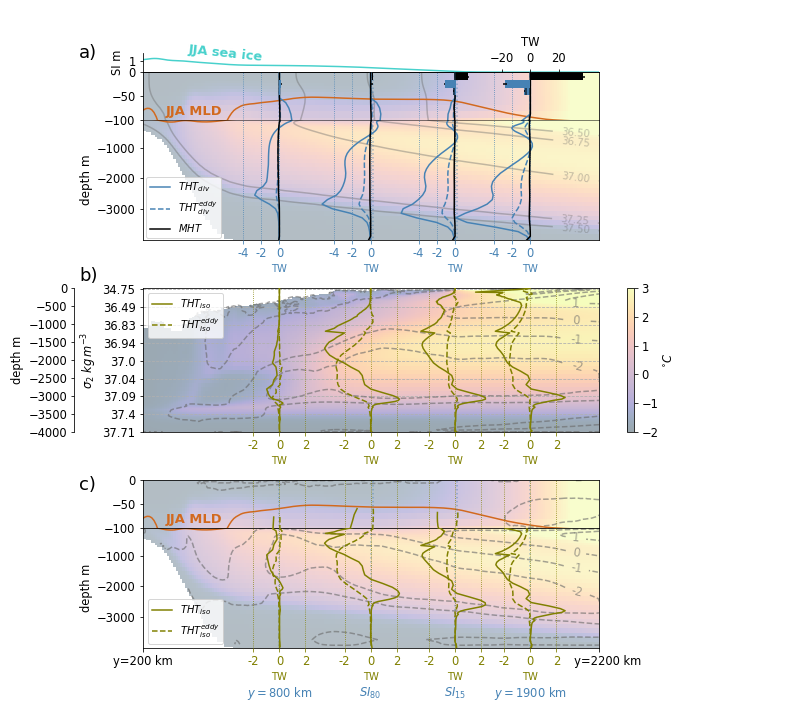

In [28]:
fig, ax = plt.subplots(7, 1, figsize=(11, 10), gridspec_kw={"height_ratios": [1, 2.5, 1, 3, 1, 1, 2.5]})


#############################################################################################################################################
#######  Upper subplot (HT vs z)#############################################################################################################
#############################################################################################################################################

##############################################
# set some parameters and prepare the subplots
##############################################
bottomylim = -4000
topylim = 0

ax01 = ax[1]
ax0 = ax[0]
axice = ax0.inset_axes([0, 1, 1, 0.4])
Dmax = 55
bottomylim=-4000
upper_lower = -100

plotlat = mean.YG.values
plotz = mean.Z.isel(Z=slice(0, Dmax+1)).values
shelfmask = (T / T).where(T != 0)

##############################################
# main part of upper subplot
##############################################
a = ax01.pcolormesh(plotlat, plotz, T.isel(Z=slice(0, Dmax)) * shelfmask, 
                    cmap=cmo.thermal, alpha=0.3, vmin=-2, vmax=3)
b = ax01.contour(plotlat, plotz, (SIG2.isel(Z=slice(0, Dmax)) - 1000. * shelfmask),
                 colors="dimgray", levels=[36.5, 36.75, 37.0, 37.25, 37.5], alpha=0.4)
fmt = {}
strs = [int(b.levels[i] * 1e-6) for i in range(0, len(b.levels))]
for l, s in zip(b.levels, strs):
    fmt[l] = s
ax01.clabel(b, b.levels, inline=True, fontsize=10, 
            manual=[(2.1e6, -400), (2.1e6, -900), (2.1e6, -2000), (2.1e6, -3000), (2.1e6, -3500)])
plt.colorbar(a, label=r"$^{\circ}$C", ax=ax01)
c = ax01.plot(plotlat, -MLD.where(plotlat < 1e6), color="chocolate")
ax01.set_xlim(0.2e6, 2.2e6)
ax01.set_ylim(bottomylim, upper_lower)
ax01.set_ylabel("depth m", fontsize=12)
ax01.set_xticks([])
ax01.set_xlabel("")
ax01.set_yticks([-3000, -2000, -1000])
ax01.spines.top.set_visible(False)
ax01.tick_params(axis='both', which='major', labelsize=11.5)

# add insets for HT

HTxmin = -1e13
HTxmax = 1e13
HTxticks = [-4e12, -2e12, 0]
HTxticklabels = [-4, -2, 0]

trans_args = {"color1": "steelblue", 
              "color2": "steelblue", 
              "color3": "k",
              "ls1": "-", 
              "ls2": "--", 
              "ls3": "-",
              "label1": "$THT_{div}$",
              "label2": "$THT_{div}^{eddy}$",
              "label3": "$MHT$",
              "xlabel": "TW",
              "bottomylim": bottomylim,
              "topylim": upper_lower,
              "HTxmin": HTxmin,
              "HTxmax": HTxmax,
              "HTxticks": HTxticks,
              "HTxticklabels": HTxticklabels
             }

axtrans0 = ax01.inset_axes([0.65, 0., 0.4, 1])
axtrans(axtrans0, THTdiv_outside_ML_190, THTdiveddy_outside_ML_190, MHT_outside_ML_190, 
        plotz, trans_args)

axtrans1 = ax01.inset_axes([0.485, 0., 0.4, 1])
axtrans(axtrans1, THTdiv_outside_ML_S15, THTdiveddy_outside_ML_S15, MHT_outside_ML_S15, 
        plotz, trans_args)

axtrans2 = ax01.inset_axes([0.3, 0., 0.4, 1])
axtrans(axtrans2, THTdiv_outside_ML_S80, THTdiveddy_outside_ML_S80, MHT_outside_ML_S80, 
        plotz, trans_args)

axtrans3 = ax01.inset_axes([0.1, 0., 0.4, 1])
axtrans(axtrans3, THTdiv_outside_ML_080, THTdiveddy_outside_ML_080, MHT_outside_ML_080, 
        plotz, trans_args)

axtrans3.legend(bbox_to_anchor=(0.21, 0.57))

# add zero-lines of insets

ax01.vlines(190 * 1e4, -4200, 0, ls=":", color="steelblue", alpha=0.5)
ax01.vlines(SIedge15 * 1e4, -4200, 0, ls=":", color="steelblue", alpha=0.5)
ax01.vlines(SIedge80 * 1e4, -4200, 0, ls=":", color="steelblue", alpha=0.5)
ax01.vlines(80 * 1e4, -4200, 0, ls=":", color="steelblue", alpha=0.5)


##############################################
# zoom to the upper 100 m
##############################################

a = ax0.pcolormesh(plotlat, plotz, T.isel(Z=slice(0, Dmax)) * shelfmask, 
                  cmap=cmo.thermal, alpha=0.3, vmin=-2, vmax=3)
b = ax0.contour(plotlat, plotz, (SIG2.isel(Z=slice(0, Dmax)) - 1000.) * shelfmask,
               colors="dimgray", levels=[36.5, 36.75, 37.0, 37.25, 37.5], alpha=0.4)
fmt = {}
strs = [int(b.levels[i] * 1e-6) for i in range(0, len(b.levels))]
for l, s in zip(b.levels, strs):
    fmt[l] = s
c = ax0.plot(plotlat, (-MLD), color="chocolate")
plt.colorbar(a, label=r"$^{\circ}$C", ax=ax0)
ax0.set_xlim(0.2e6, 2.2e6)
ax0.set_ylim(upper_lower, 0)
ax0.set_xticks([])
ax0.spines.bottom.set_visible(False)
ax0.text(0.3e6, -90, "JJA MLD", fontsize=13, fontweight="bold", color="chocolate")
ax0.tick_params(axis='y', which='major', labelsize=11.5)

# add the seaice on top

d = axice.plot(plotlat, SIheff.SIheff, color="mediumturquoise")
axice.set_xlim(0.2e6, 2.2e6)
axice.set_ylim(0.01, 1.7)
axice.set_yticks([1])
axice.set_xticks([])
axice.set_ylabel("SI m", fontsize=11.5)
axice.spines.right.set_visible(False)
axice.spines.top.set_visible(False)
axice.text(0.4e6, 1, "JJA sea ice", fontsize=13, fontweight="bold", color="mediumturquoise", rotation=-6)
axice.tick_params(axis='y', which='major', labelsize=11.5)
plt.subplots_adjust(top=0.8)

# add insets for HT

trans_args["topylim"] = topylim
trans_args["bottomylim"] = upper_lower

axtrans0 = ax0.inset_axes([0.65, 0., 0.4, 1])
axtrans(axtrans0, THTdiv_outside_ML_190, THTdiveddy_outside_ML_190, MHT_outside_ML_190, 
        plotz, trans_args)

axtrans1 = ax0.inset_axes([0.485, 0., 0.4, 1])
axtrans(axtrans1, THTdiv_outside_ML_S15, THTdiveddy_outside_ML_S15, MHT_outside_ML_S15, 
        plotz, trans_args)

axtrans2 = ax0.inset_axes([0.3, 0., 0.4, 1])
axtrans(axtrans2, THTdiv_outside_ML_S80, THTdiveddy_outside_ML_S80, MHT_outside_ML_S80, 
        plotz, trans_args)

axtrans3 = ax0.inset_axes([0.1, 0., 0.4, 1])
axtrans(axtrans3, THTdiv_outside_ML_080, THTdiveddy_outside_ML_080, MHT_outside_ML_080, 
        plotz, trans_args)

axice.set_title("")

ax0.vlines(190 * 1e4, -4200, 0, ls=":", color="steelblue", alpha=0.5)
ax0.vlines(SIedge15 * 1e4, -4200, 0, ls=":", color="steelblue", alpha=0.5)
ax0.vlines(SIedge80 * 1e4, -4200, 0, ls=":", color="steelblue", alpha=0.5)
ax0.vlines(80 * 1e4, -4200, 0, ls=":", color="steelblue", alpha=0.5)

# add the barplots to the mixed layer

cats = np.arange(0, 3)
hbar_width = 0.25
hbar_height_up = 0.5
xmin = -40
xmax = 40

tmp = tof["horizontal HT within ML"]["at y=80"]
vals0a = np.array([tmp["CME_mean"], tmp["transient_mean"], tmp["mean_mean"]])
errs0a = np.array([tmp["CME_std"], tmp["transient_std"], tmp["mean_std"]])
bar_ax0a = ax0.inset_axes([0.175, 0.5, hbar_width, hbar_height_up])
bar0a = hbars(cats, vals0a, errs0a, bar_ax0a, 1)
bar_ax0a.set_xlim(xmin, xmax)

tmp = tof["horizontal HT within ML"]["at 80% ice"]
vals1a = np.array([tmp["CME_mean"], tmp["transient_mean"], tmp["mean_mean"]])
errs1a = np.array([tmp["CME_std"], tmp["transient_std"], tmp["mean_std"]])
bar_ax1a = ax0.inset_axes([0.378, 0.5, hbar_width, hbar_height_up])
bar1a = hbars(cats, vals1a, errs1a, bar_ax1a, 1)
bar_ax1a.set_xlim(xmin, xmax)

tmp = tof["horizontal HT within ML"]["at 15% ice"]
vals2a = np.array([tmp["CME_mean"], tmp["transient_mean"], tmp["mean_mean"]])
errs2a = np.array([tmp["CME_std"], tmp["transient_std"], tmp["mean_std"]])
bar_ax2a = ax0.inset_axes([0.562, 0.5, hbar_width, hbar_height_up])
bar2a = hbars(cats, vals2a, errs2a, bar_ax2a, 1)
bar_ax2a.set_xlim(xmin, xmax)

tmp = tof["horizontal HT within ML"]["at y=190"]
vals3a = np.array([tmp["CME_mean"], tmp["transient_mean"], tmp["mean_mean"]])
errs3a = np.array([tmp["CME_std"], tmp["transient_std"], tmp["mean_std"]])
bar_ax3a = ax0.inset_axes([0.725, 0.5, hbar_width, hbar_height_up])
bar3a = hbars(cats, vals3a, errs3a, bar_ax3a, 1)
bar_ax3a.set_xlim(xmin, xmax)
bar_ax3a.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
bar_ax3a.set_xticks([-20, 0, 20], loc="top")
#bar_ax3a.set_xticklabels([-200, 0, 200])
bar_ax3a.set_title("TW", fontsize=11.5)
bar_ax3a.tick_params(axis='x', which='major', labelsize=11.5)

ax01.hlines(-100, 0, 3e6, lw=0.5, color="k", ls="-", zorder=99)

#############################################################################################################################################
#######  Middle subplot (iso vs sigma)#######################################################################################################
#############################################################################################################################################

##############################################
# main part of middle subplot
##############################################

plot = ax[3].pcolormesh(T_rho.YG, isodepthmean, T_rho.t_rho.where(T_rho.t_rho != 0, other=np.nan).T, 
                        vmin=-2, vmax=3, cmap=cmo.thermal, alpha=0.4)
plt.colorbar(plot, ax=ax[3]).set_label(label=r"$^{\circ}C$", fontsize=11.5)
b = ax[3].contour(MOC_res.YG, isodepthmean, -MOC_res.T,
                  colors="dimgray", levels=[-3e6, -2e6, -1e6, 0, 1e6], linestyles="--", alpha=0.6)
fmt = {}
strs = [int(b.levels[i] * 1e-6) for i in range(0, len(b.levels))]
for l, s in zip(b.levels, strs):
    fmt[l] = s
ax[3].clabel(b, b.levels, inline=True, fontsize=11.5, manual=[(2.1e6, -400), (2.1e6, -900), (2.1e6, -1500), (2.1e6, -2400)], fmt=fmt)

ax32 = ax[3].twinx()
ax32.spines["left"].set_position(("axes", -0.15))
make_patch_spines_invisible(ax32)
ax32.spines["left"].set_visible(True)
ax32.yaxis.set_label_position('left')
ax32.yaxis.set_ticks_position('left')
ax[3].set_ylim(z_ticks_plot.min(), z_ticks_plot.max())
ax[3].set_yticks(z_ticks)
ax[3].set_yticklabels(z_ticks_plot);
ax32.set_yticks(z_ticks);
ax32.set_ylabel("depth m", fontsize=11.5)
ax[3].set_xlim(0.2e6, 2.2e6)

ax[3].vlines(190 * 1e4, 38, 34.5, ls=":", color="steelblue", alpha=1)
ax[3].vlines(157 * 1e4, 38, 34.5, ls=":", color="steelblue", alpha=1)
ax[3].vlines(120 * 1e4, 38, 34.5, ls=":", color="steelblue", alpha=1)
ax[3].vlines(80 * 1e4, 38, 34.5, ls=":", color="steelblue", alpha=1)

ax[3].set_xticks([])
ax[3].set_xlabel("")
ax[3].set_ylabel(r"$\sigma_{2}\,\,kg\,m^{-3}$", fontsize=11.5)

ax[3].tick_params(axis='y', which='major', labelsize=11.5)
ax32.tick_params(axis='y', which='major', labelsize=11.5)

# add insets for HT

trans_args["topylim"] = topylim
trans_args["bottomylim"] = bottomylim
trans_args["HTxmin"] = -0.7e13
trans_args["HTxmax"] = 0.7e13
trans_args["HTxticks"] = [-2e12, 0, 2e12]
trans_args["HTxticklabels"] = [-2, 0, 2]
trans_args["xlabel"] = "TW"
trans_args["label1"] = r"$THT_{iso}$"
trans_args["label2"] = r"$THT^{eddy}_{iso}$"
trans_args["color1"] = "olive" 
trans_args["color2"] = "olive"

axtrans30 = ax[3].inset_axes([0.65, 0., 0.4, 1])
axtrans(axtrans30,
        isopycnal.iso_total.isel(YG=190),
        isopycnal.iso_totaleddy.isel(YG=190),
        np.array([None, None]),
        isodepthmean.values,
        trans_args)

axtrans31 = ax[3].inset_axes([0.485, 0., 0.4, 1])
axtrans(axtrans31,
        isopycnal.iso_total.isel(YG=SIedge15),
        isopycnal.iso_totaleddy.isel(YG=SIedge15),
        np.array([None, None]),
        isodepthmean.values,
        trans_args)

axtrans32 = ax[3].inset_axes([0.3, 0., 0.4, 1])
axtrans(axtrans32,
        isopycnal.iso_total.isel(YG=SIedge80),
        isopycnal.iso_totaleddy.isel(YG=SIedge80), 
        np.array([None, None]),
        isodepthmean.values,
        trans_args)

axtrans33 = ax[3].inset_axes([0.1, 0., 0.4, 1])
axtrans(axtrans33,
        isopycnal.iso_total.isel(YG=80),
        isopycnal.iso_totaleddy.isel(YG=80), 
        np.array([None, None]),
        isodepthmean.values,
        trans_args)

axtrans33.legend(loc=2, bbox_to_anchor=(-0.25, 1))

ax[3].grid(ls="--")

#############################################################################################################################################
#######  Bottom subplot (iso vs z)#######################################################################################################
#############################################################################################################################################

##############################################
# main part of lower subplot
##############################################

a = ax[6].pcolormesh(plotlat, plotz, T.isel(Z=slice(0, Dmax)) * shelfmask, 
                     cmap=cmo.thermal, alpha=0.3, vmin=-2, vmax=3)
b = ax[6].contour(MOC_res_z.YG, MOC_res_z.Z, -MOC_res_z.T * shelfmask.values,
                  colors="dimgray", levels=[-3e6, -2e6, -1e6, 0, 1e6], linestyles="--", alpha=0.6)
fmt = {}
strs = [int(b.levels[i] * 1e-6) for i in range(0, len(b.levels))]
for l, s in zip(b.levels, strs):
    fmt[l] = s
ax[6].clabel(b, b.levels, inline=True, fontsize=11.5, manual=[(2.1e6, -400), (2.1e6, -900), (2.1e6, -1500), (2.1e6, -2400)], fmt=fmt)

c = ax[6].plot(plotlat, -MLD.where(plotlat < 1e6), color="chocolate")
ax_lines_labels = ax[6].get_legend_handles_labels()
plt.colorbar(a, label=r"$^{\circ}$C", ax=ax[6])
ax[6].set_xlim(0.2e6, 2.2e6)
ax[6].set_ylim(bottomylim, upper_lower)
ax[6].set_ylabel("depth m", fontsize=11.5)
ax[6].set_yticks([-3000, -2000, -1000])
#ax[6].spines.top.set_visible(False)
ax[6].set_xticks([0.2e6, 2.2e6])
ax[6].set_xticklabels(["y=200 km", "     y=2200 km"])
ax[6].set_xlabel("")
ax[6].tick_params(axis='both', which='major', labelsize=11.5)

# add insets for HT
trans_args["topylim"] = upper_lower
trans_args["bottomylim"] = bottomylim

axtrans60 = ax[6].inset_axes([0.65, 0., 0.4, 1])
axtrans(axtrans60,
        isopycnal.iso_total.where(isodepthmean190 <= (-MLD)).isel(YG=190),
        isopycnal.iso_totaleddy.where(isodepthmean190 <= (-MLD)).isel(YG=190),
        np.array([None, None]),
        isodepthmean190.values,
        trans_args)

axtrans61 = ax[6].inset_axes([0.485, 0., 0.4, 1])
axtrans(axtrans61,
        isopycnal.iso_total.where(isodepthmeanSI15 <= (-MLD)).isel(YG=SIedge15),
        isopycnal.iso_totaleddy.where(isodepthmeanSI15 <= (-MLD)).isel(YG=SIedge15), 
        np.array([None, None]),
        isodepthmeanSI15.values,
        trans_args)

axtrans62 = ax[6].inset_axes([0.3, 0., 0.4, 1])
axtrans(axtrans62,
        isopycnal.iso_total.where(isodepthmeanSI80 <= (-MLD)).isel(YG=SIedge80),
        isopycnal.iso_totaleddy.where(isodepthmeanSI80 <= (-MLD)).isel(YG=SIedge80), 
        np.array([None, None]),
        isodepthmeanSI80.values,
        trans_args)

axtrans63 = ax[6].inset_axes([0.1, 0., 0.4, 1])
axtrans(axtrans63,
        isopycnal.iso_total.where(isodepthmean80 <= (-MLD)).isel(YG=80),
        isopycnal.iso_totaleddy.where(isodepthmean80 <= (-MLD)).isel(YG=80),
        np.array([None, None]),
        isodepthmean80.values,
        trans_args)

axtrans63.legend(loc=2, bbox_to_anchor=(-0.25, 0.45))

ax[6].text(190 * 1e4, -5600, "$y=1900$ km", color="steelblue", ha="center", fontsize=11.5)
ax[6].text(157 * 1e4, -5600, "$SI_{15}$", color="steelblue", ha="center", fontsize=11.5)
ax[6].text(120 * 1e4, -5600, "$SI_{80}$", color="steelblue", ha="center", fontsize=11.5)
ax[6].text(80 * 1e4, -5600, "$y=800$ km", color="steelblue", ha="center", fontsize=11.5);

ax[6].vlines(190 * 1e4, -4200, 0, ls=":", color="steelblue", alpha=0.5)
ax[6].vlines(157 * 1e4, -4200, 0, ls=":", color="steelblue", alpha=0.5)
ax[6].vlines(120 * 1e4, -4200, 0, ls=":", color="steelblue", alpha=0.5)
ax[6].vlines(80 * 1e4, -4200, 0, ls=":", color="steelblue", alpha=0.5)


a = ax[5].pcolormesh(plotlat, plotz, T.isel(Z=slice(0, Dmax)) * shelfmask, 
                     cmap=cmo.thermal, alpha=0.3, vmin=-2, vmax=3)
b = ax[5].contour(MOC_res_z.YG, MOC_res_z.Z, -MOC_res_z.T * shelfmask.values,
                  colors="dimgray", levels=[-3e6, -2e6, -1e6, 0, 1e6], linestyles="--", alpha=0.6)
fmt = {}
strs = [int(b.levels[i] * 1e-6) for i in range(0, len(b.levels))]
for l, s in zip(b.levels, strs):
    fmt[l] = s
ax[5].clabel(b, b.levels, inline=True, fontsize=10, manual=[(2.1e6, -400), (2.1e6, -900), (2.1e6, -1500), (2.1e6, -2400)], fmt=fmt)

c = ax[5].plot(plotlat, -MLD, color="chocolate", label="MLD")
ax_lines_labels = ax[5].get_legend_handles_labels()
plt.colorbar(a, label=r"$^{\circ}$C", ax=ax[5])
ax[5].set_xlim(0.2e6, 2.2e6)
ax[5].set_ylim(upper_lower, 0)
ax[5].set_ylabel("")
ax[5].set_xlabel("")
ax[5].set_xticks([])
ax[5].text(0.3e6, -90, "JJA MLD", fontsize=13, fontweight="bold", color="chocolate")

ax[5].vlines(190 * 1e4, -4200, 0, ls=":", color="steelblue", alpha=0.5)
ax[5].vlines(SIedge15 * 1e4, -4200, 0, ls=":", color="steelblue", alpha=0.5)
ax[5].vlines(SIedge80 * 1e4, -4200, 0, ls=":", color="steelblue", alpha=0.5)
ax[5].vlines(80 * 1e4, -4200, 0, ls=":", color="steelblue", alpha=0.5)
ax[5].tick_params(axis='y', which='major', labelsize=11.5)

trans_args["topylim"] = topylim
trans_args["bottomylim"] = upper_lower

axtrans50 = ax[5].inset_axes([0.65, 0., 0.4, 1])
axtrans(axtrans50,
        isopycnal.iso_total.where(isodepthmean190 <= (-MLD)).isel(YG=190),
        isopycnal.iso_totaleddy.where(isodepthmean190 <= (-MLD)).isel(YG=190),
        np.array([None, None]),
        isodepthmean190.values,
        trans_args)

axtrans51 = ax[5].inset_axes([0.485, 0., 0.4, 1])
axtrans(axtrans51,
        isopycnal.iso_total.where(isodepthmeanSI15 <= (-MLD)).isel(YG=SIedge15),
        isopycnal.iso_totaleddy.where(isodepthmeanSI15 <= (-MLD)).isel(YG=SIedge15), 
        np.array([None, None]),
        isodepthmeanSI15.values,
        trans_args)

axtrans52 = ax[5].inset_axes([0.3, 0., 0.4, 1])
axtrans(axtrans52,
        isopycnal.iso_total.where(isodepthmeanSI80 <= (-MLD)).isel(YG=SIedge80),
        isopycnal.iso_totaleddy.where(isodepthmeanSI80 <= (-MLD)).isel(YG=SIedge80), 
        np.array([None, None]),
        isodepthmeanSI80.values,
        trans_args)

axtrans53 = ax[5].inset_axes([0.1, 0., 0.4, 1])
axtrans(axtrans53,
        isopycnal.iso_total.where(isodepthmean80 <= (-MLD)).isel(YG=80),
        isopycnal.iso_totaleddy.where(isodepthmean80 <= (-MLD)).isel(YG=80),
        np.array([None, None]),
        isodepthmean80.values,
        trans_args)

plt.subplots_adjust(bottom=0.1, top=0.9, left=0.18, right=0.9, hspace=0.0)
no_axes(ax[2])
no_axes(ax[4])

fig.text(0.1, 0.92, "a)", fontsize=18)
fig.text(0.1, 0.61, "b)", fontsize=18)
fig.text(0.1, 0.32, "c)", fontsize=18)

fig.delaxes(fig.axes[7])
fig.delaxes(fig.axes[7])
fig.delaxes(fig.axes[9])
fig.delaxes(fig.axes[9])
fig.axes[7].tick_params(axis="y", labelsize=11.5)

plt.savefig("fig07-combined_z_dependence.png", dpi=300)